# ADA - Project Milestone 2: 
# *Analysis of speech behaviours between genders*

## Context

In this project, we are going to analyze data from Quotebank. Quotebank, as the name suggests, is an open corpus which gathers 178 million quotations from 2008 to 2020. Still, in this project, we will only focus on the most recent quotations, being from 2015 to 2020.

We are interested in using this dataset to answer the following question: Do speech behaviours related to confidence and uncertainty vary between men and women?

To answer this question, we'll go through the following points:

1. To what extent can we observe the differences in communicative acts in relation to gender within a professional area? Are there noticeable differences between those professional areas?
3. What are the roles of environment (nationality), culture/tradition (religion, ethnic groups), and education (whether the speaker obtained an academic degree) in determining those differences in speech between men and women? How are the lines drawn between the language we use and the environment around us?
4. Has there been a possible change over time (from 2015 to 2020)?

In order to have access to the speakers' information (e.g., speakers' genders), we use the open source data from wikidata (https://www.wikidata.org/wiki/Wikidata:Main_Page).

To analyse speech uncertainty, we use an uncertainty detection classifier, adapted from the following paper "P. A. Jean, S. Harispe, S. Ranwez, P. Bellot, and J. Montmain, “[Uncertainty detection in natural language: A probabilistic model](https://www.researchgate.net/publication/303842922)” ACM Int. Conf. Proceeding Ser., vol. 13-15-June, no. June, 2016, doi: 10.1145/2912845.2912873".

## Table of contents

[1. Pre-processing of the data](#pre-processing) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Functions](#1functions)
- [Merging files from wikidata into one file containing the 9 million speakers](#1merging)
- [1.1 Loading and pre-processing of Quotebank data](#1.1)
- [1.2 Analysis of the quotes from Quotebank](#1.2)
- [1.3 Loading wikidata labels](#1.3) 
- [1.4 Pre-processing of wikidata](#1.4)
- [1.5 Exploratory Data Analysis of wikidata](#1.5)

[2. Creation of our sub data frames](#dataframes)
- [Imports](#2imports)
- [Functions](#2functions)
- [2.1 Creation of professional fields](#2.1)
- [2.2 Creation of sub-dataframes](#2.2) 
- [2.3 Creation of Data Frames with English Quotes only](#2.3)
- [2.4 Saving of all sub data frames](#2.4)

[3. Classification of the quotes](#classifier)
- [Pathways](#3pathways)
- [Functions](#3functions)
- [3.1 Reading of all sub data frames](#3.1)
- [3.2 Creation of the text files](#3.2)
- [3.3 Use of the uncertainty detection classifier](#3.3) 

[4. Statistical-analysis](#stat_analysis)
- [Imports](#4imports)
- [Functions](#4functions)
- [4.1 Gender distribution accross occupations](#4.1)
- [4.2 Analysis of the gender distribution per professions](#4.2) 
- [4.3 Background influence](#4.3)
- [4.4 Possible variation from 2015 to 2020](#4.4)

[5. Interpretation of results](#interpretation)

## 1. Pre-processing of the data <a class = anchor id="pre-processing"></a>

### Imports <a class = anchor id="1imports"></a>

Let's start by importing our libraries. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import detect
#import plotly
#import plotly.graph_objects as go
import mpld3

### Pathways <a class = anchor id="1pathways"></a>

In order to run this project, one needs to download the directories and files from the following drive: https://drive.google.com/drive/folders/1UgvnLUFhs14NDcZYH6NuZx2f_YC5i06N?usp=sharing. All directories need to be added in the same directory as this notebook. The data folders "Data" and "Data_parquet" are already important for the upcoming [1. Pre-processing of the data](#pre-processing); the two other directories ("Classifier" and "txt_files") will be needed in the [3. Classification of the quotes](#classifier).

In [26]:
# DATA_PATH contains all data frames
DATA_PATH = 'Data/'
# PATH_PARQUET contains all the data from wikidata
PATH_PARQUET = 'Data_parquet/'
seed = 2

### Functions <a class = anchor id="1functions"></a>

The following function is needed for the pre-processing.

In [3]:
def saving_wikidata(path):
    """
    Transforms all the wikidata files in one dataset saved as pickle. 
    This allows to load the file and use it more quickly and easily.
    Input:
        * path : pathway where to save the pickle file
    """
    wikidata_all = pd.DataFrame()
    for i in range(1,16):
        if i < 10:
            DATA_FILE = 'part-0000{}-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet'.format(i)
        else:
            DATA_FILE = 'part-000{}-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet'.format(i)
        wikidata = pd.read_parquet(PATH_PARQUET + DATA_FILE)
        wikidata_all = pd.concat([wikidata_all, wikidata])
    wikidata_all.to_pickle(path)

def det(x):
    """
    Detects the language a quote.
    Input:
        * x : one quote
    Output:
        * lang : language of the quote
    """
    try:
        lang = detect(x)
    except:
        lang = 'Other'
    return lang

### Merging files from wikidata into one file containing the 9 million speakers <a class = anchor id="1merging"></a>

Here, we create the file "wikidata_all.pck" containing all the raw data from wikidata. We already ran this cell and the file can be found in "Data". As this is a huge dataset, we save the file as pickle, as this is much less comutationally costly than directly working with the data.

In [4]:
""" Only intented to be run once
saving_wikidata(DATA_PATH + "wikidata_all.pck")""";

### 1.1. Loading and pre-processing of Quotebank data <a class = anchor id="1.1"></a>

The function `clean_quotebank` (in [Functions](#2functions) below) does a first cleaning of the quotebank dataset by leaving behind quotes from unknown speakers as they would not be useful towards our study. We chose to also drop the quotes from uncertain speakers, i.e. when the speaker probability was below 0.5. As this is a computationally costly operation, the cleaning is performed at the same time as we create our quotebank sub dataframes ([2. Creation of our sub data frames](#dataframes)).

### 1.2 Analysis of the quotes from Quotebank <a class = anchor id="1.2"></a>

We take a random sample of our dataframe to analyze the language distribution in the dataset. More information about this dataframe (saved as "df_no_conditions_2020.pck" in Data) will be provided in the [2. Creation of our sub data frames](#dataframes). We consider that this sample selected randomly is representative of the whole dataset.

In [5]:
df_no_conditions_2020 = pd.read_pickle(DATA_PATH + "df_no_conditions_2020.pck")

In [62]:
#del df_no_conditions_2020

For reproducibility, a seed is fixed for the entire dataframe (`seed` = 2). 

In [6]:
small_df = df_no_conditions_2020.sample(n = 300, random_state = seed)

In [63]:
#del small_df

Here is a glampse at some quotes.

In [7]:
print(small_df.shape)
small_df.head(3)

(300, 24)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,aliases,...,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
65382,2020-01-16-037739,I will seek to mend fences with our neighbouri...,John Campion,Q24572630,2020-01-16 06:01:00,1,"[[John Campion, 0.6249], [None, 0.3751]]",[http://www.shropshirestar.com/news/crime/2020...,E,[John-Paul Campion],...,None,None,[Q82955],[Q9626],None,Q24572630,John Campion,None,item,None
27097,2020-02-13-119432,"We're training at Aston Villa again, mid journ...",Chris Beech,Q5105871,2020-02-13 17:27:16,1,"[[Chris Beech, 0.6725], [None, 0.238], [Dean S...",[https://www.birminghammail.co.uk/sport/footba...,E,None,...,None,None,[Q937857],None,None,Q5105871,Chris Beech,None,item,None
25289,2020-01-23-019530,Exports of firearms and related items that do ...,R. Clarke Cooper,Q7273550,2020-01-23 22:15:25,1,"[[R. Clarke Cooper, 0.8201], [None, 0.1799]]",[https://www.cnbc.com/2020/01/23/gun-exports-g...,E,[René Clarke Cooper],...,None,None,"[Q11986654, Q189290, Q82955]",[Q29468],None,Q7273550,R. Clarke Cooper,None,item,[Q682443]


We use langdetect to identify quotations language.

In [8]:
small_df['quote_language'] = small_df['quotation'].apply(lambda x: det(x))

Let's print all languages contained in `small_df`.

In [9]:
small_df['quote_language'].unique()

array(['en', 'fr', 'af', 'ca', 'sw'], dtype=object)

We see that not all quotes are in English. Therefore, in part [2.3 Creation of Data Frames with English Quotes only](#2.3), we will select only the English quotes from our data frames.

Before the visualisation, we define a color palette that will be used carefully throughout the project to be robust for color blind people.

In [3]:
color_palette = sns.color_palette("rocket",10)

Let's visualise the languages in this sample of our dataset.

In [11]:
language_dist = small_df.groupby('quote_language').size()
language_dist = language_dist.div(language_dist.sum(axis = 0), axis = 0)

In [64]:
#del language_dist

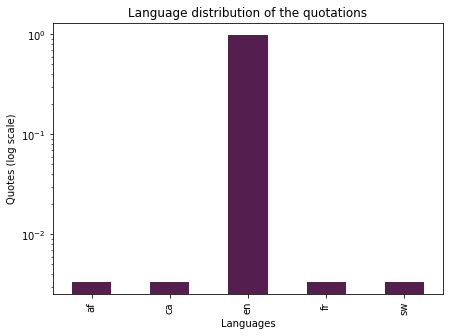

In [12]:
fig = plt.figure()
language_dist.plot(kind = 'bar', figsize = [7,5], color = color_palette[1])
plt.xlabel('Languages')
plt.ylabel('Quotes (log scale)')
plt.yscale('log')
plt.title('Language distribution of the quotations');

In [13]:
html_str = mpld3.fig_to_html(fig)
Html_file= open("Images/language_dist_plot.html","w")
Html_file.write(html_str)
Html_file.close()

In [14]:
'''language_dist = small_df.groupby('quote_language').size()
language_dist = language_dist.div(language_dist.sum(axis = 0), axis = 0)''';

In [15]:
'''fig = go.Figure()
language_dist = small_df.groupby('quote_language').size()
language_dist = language_dist.div(language_dist.sum(axis = 0), axis = 0)
ax = language_dist.plot(kind = 'bar', figsize = [7,5], color = color_palette[1])
ax.set_title('Language distribution of the quotations')
ax.set_ylabel('Quotes (log scale)')
ax.set_xlabel('Languages')
ax.set_yscale('log')
plt.show()''';

We save the image for the data story. All images have already been created and can be found in the folder "Images".

In [16]:
'''fig.write_html("Images/language_dist_plot.html")'''

'fig.write_html("Images/language_dist_plot.html")'

We observe that the dataset is composed in vast majority of english quotes (99%) but it also contains quotes coming from different languages like French, Malaysian and Swahili.

### 1.3 Loading wikidata labels <a class = anchor id="1.3"></a>

Wikidata labels are encoded in items called QIDs, to map them back to human readable labels, we upload the following dataset.

In [4]:
qid_label = pd.read_csv(DATA_PATH+'wikidata_labels_descriptions_quotebank.csv.bz2', \
                        compression = 'bz2', index_col = 'QID')

Let's have a quick look at this data frame.

In [18]:
qid_label.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


### 1.4 Pre-processing of wikidata <a class = anchor id="1.4"></a>

To be able to find information about the speakers, we use wikidata. Let's start by creating a data frame of all the speakers from our pickle file "wikidata_all.pck".

In [19]:
wikidata_all = pd.read_pickle("Data/wikidata_all.pck")
wikidata_all.shape

(8583613, 15)

In [65]:
#del wikidata_all

We now search for possible redundant speakers.

In [20]:
wikidata_all['id'].is_unique

True

As this returns `True`, we can see that there are no duplicate speakers in wikidata. We'll now create a new dataframe (`cleaned_wikidata`), that will contain a clean version of the data (without modifying the original one).

In [21]:
cleaned_wikidata = wikidata_all.copy(deep = True)

In [68]:
#del cleaned_wikidata

Let's visualise this data frame.

In [22]:
cleaned_wikidata.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,None,None,None,[Q6581097],985453603,None,None,None,None,None,Q45441526,Cui Yan,None,item,None
1,None,None,[Q9903],[Q6581097],1008699604,None,None,None,None,None,Q45441555,Guo Ziyi,None,item,None
2,None,None,[Q9903],[Q6581097],1008699709,None,None,None,None,None,Q45441562,Wan Zikui,None,item,None
3,None,None,[Q9903],[Q6581097],1008699728,None,None,None,None,None,Q45441563,Lin Pei,None,item,None
4,None,None,[Q9683],[Q6581097],985261661,None,None,None,None,None,Q45441565,Guan Zhen,None,item,None


Now we want to remove rows where mandatory values for our study are missing like the name of the speaker and the gender.

In [23]:
cleaned_wikidata = cleaned_wikidata[~cleaned_wikidata.label.isin([None, "None"])]
print(cleaned_wikidata.shape)
cleaned_wikidata = cleaned_wikidata[~cleaned_wikidata.gender.isin([None, "None"])]
print(cleaned_wikidata.shape)

(8113215, 15)
(6288640, 15)


We see that there were 470.398 missing names of speakers and 1.824.575 missing speakers' genders. Our new cleaned data frame contains 6.288.640 speakers.

### 1.5 Exploratory Data Analysis of wikidata <a class = anchor id="1.5"></a>

We will now analyse the genders present in wikidata.

In [24]:
cleaned_wikidata['gender'] = cleaned_wikidata['gender'].apply(lambda x: x[0])
print("There are {} different unique genders in wikidata".format(cleaned_wikidata['gender'].unique().shape[0]))
cleaned_wikidata['gender'].unique()

There are 32 different unique genders in wikidata


array(['Q6581097', 'Q6581072', 'Q179294', 'Q1052281', 'Q48270',
       'Q2449503', 'Q18116794', 'Q12964198', 'Q15145779', 'Q189125',
       'Q859614', 'Q1097630', 'Q44148', 'Q1289754', 'Q301702',
       'Q106299064', 'Q27679684', 'Q15145778', 'Q52261234', 'Q207959',
       'Q505371', 'Q7130936', 'Q43445', 'Q96000630', 'Q27679766',
       'Q1984232', 'Q93954933', 'Q746411', 'Q48279', 'Q3177577',
       'Q1775415', 'Q6636'], dtype=object)

Let's observe their distribution.

In [25]:
gender_dist = cleaned_wikidata.groupby('gender').size()
gender_dist = gender_dist.div(gender_dist.sum(axis = 0), axis = 0)
gender_dist.index = qid_label.loc[gender_dist.index].Label.values

In [69]:
#del gender_dist

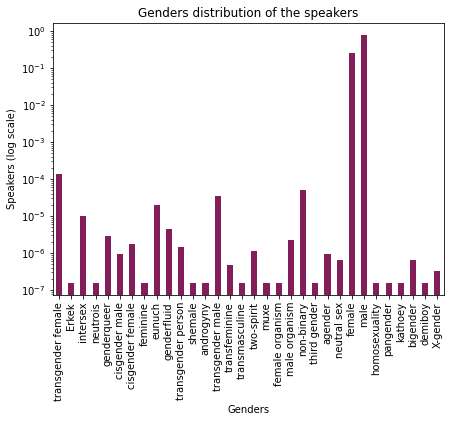

In [26]:
fig = plt.figure()
gender_dist.plot(kind = 'bar', figsize = [7, 5],  color = [color_palette[2]])
plt.xlabel('Genders')
plt.ylabel('Speakers (log scale)')
plt.yscale('log')
plt.title('Genders distribution of the speakers');

In [27]:
html_str = mpld3.fig_to_html(fig)
Html_file= open("Images/gender_dist_plot3.html","w")
Html_file.write(html_str)
Html_file.close()

In [28]:
#import plotly.graph_objects as go

In [29]:
'''fig = go.Figure()

ax = gender_dist.plot(kind = 'bar', figsize = [7,5],  color = [color_palette[2]])
ax.set_title('Genders distribution of the speakers')
ax.set_ylabel('Speakers (log scale)')
ax.set_xlabel('Genders')
ax.set_yscale('log')
plt.show()'''

"fig = go.Figure()\n\nax = gender_dist.plot(kind = 'bar', figsize = [7,5],  color = [color_palette[2]])\nax.set_title('Genders distribution of the speakers')\nax.set_ylabel('Speakers (log scale)')\nax.set_xlabel('Genders')\nax.set_yscale('log')\nplt.show()"

The image is saved.

In [30]:
'''fig.write_html("Images/gender_dist.html")'''

'fig.write_html("Images/gender_dist.html")'

We see that there are 31 genders present in wikidata. Let's now print those genders.

In [31]:
qid_label.loc[cleaned_wikidata['gender'].unique()]

,Label,Description
QID,,
Q6581097,male,"to be used in ""sex or gender"" (P21) to indicat..."
Q6581072,female,"to be used in ""sex or gender"" (P21) to indicat..."
Q179294,eunuch,castrated male human
Q1052281,transgender female,female person who was assigned a different gen...
Q48270,non-binary,range of gender identities that are not exclus...
Q2449503,transgender male,person assigned to the female sex at birth who...
Q18116794,genderfluid,gender identity which doesn't conform to fixed...
Q12964198,genderqueer,range of gender identities that are not exclus...
Q15145779,cisgender female,female person who was assigned female at birth


We define the male and female genders for further analysis.

In [5]:
male_label = "Q6581097"
female_label= "Q6581072"

Let's compute the proportion of non-male and non-female genders.

In [33]:
gender_dist[(gender_dist.index != male_label) & (gender_dist.index != female_label)].sum()

1.0

We can see that less than 0.03% of the data is neither considered a male or a female. For simplicity in our study we will ignore those cases.

In [34]:
cleaned_wikidata = cleaned_wikidata[cleaned_wikidata.gender.isin([male_label, female_label])]

We know creates an occupation data frame where everyone's occupation is known (not `None`).

In [35]:
"""Only intented to be run once 
wiki_occupation = cleaned_wikidata[~cleaned_wikidata['occupation'].isin([None])]""";

Then, we create a complete data frame where occupation, religion, nationality, ethnic_group and academic_degree are known for every speaker in the dataset.

In [36]:
""" Only intented to be run once 
wiki_background = wiki_occupation[~(wiki_occupation['religion'].isin([None, "None"]) & 
                        wiki_occupation['nationality'].isin([None, "None"]) &
                        wiki_occupation['ethnic_group'].isin([None, "None"]) & 
                        wiki_occupation['academic_degree'].isin([None, "None"]))]""";

We save those data frames as pickle for further analysis. We already ran the following cell and the files can be found in "Data".

In [37]:
""" Only intented to be run once 
wiki_occupation.to_pickle(DATA_PATH + "wiki_occupation.pck")
wiki_background.to_pickle(DATA_PATH + "wiki_background.pck")""";

Now that all the pre-processing is done, we can start our analysis. 

## 2.  Creation of our sub data frames <a class = anchor id="dataframes"></a>

First, we will focus on the initial matter, being to what extent we can observe the differences in communicative acts in relation to gender within a professional area and whether there are noticeable differences between those professional areas.

### Imports <a class = anchor id="2imports"></a>

First we import Empath, a tool for analyzing text across lexical categories.

In [38]:
from empath import Empath

### Functions <a class = anchor id="2functions"></a>

Let's define the functions needed for this part.

In [39]:
def add_columns(column, target, init_df, name_column):
    """
    Checks if a target ('politician', 'male', 'female' etc...) is in a certain column.
    If it is, we return True in an additional column (name_column).
    Inputs:
        * column : name of column to search for target
        * target : item of interest 
        * init_df : initial data frame
        * name_column : name of new column of booleans
    Output:
        * final_df : dataframe with new column and only rows which contains the item
    """
    final_df = init_df.copy(deep = True)
    final_df[name_column] = final_df[column].apply(lambda x: np.any(x) in target)
    return final_df

def extracting_sub_df(quotebank, wikidata, column):
    """
    Creates a sub dataframe with information from quotebank and wikidata.
    We only take the rows in column which are True.
    Inputs:
        * quotebank : data frame extracted from quotebank
        * wikidata : data frame extracted from wikidata
        * column : column on which we base the merge
    Output:
        * sub_df : merged dataframe 
    """
    merged_df = pd.merge(quotebank, wikidata, left_on = 'speaker', right_on = 'label')
    merged_df['qids'] = merged_df['qids'].apply(lambda x : x[0])
    merged_df = merged_df[merged_df['qids'] == merged_df['id']]
    sub_df = merged_df[merged_df[column] == True]
    return sub_df

def clean_quotebank(df):
    """ 
    Cleans quotebank dataset by droping quotes from unknown speakers and
    quotes where the speaker is uncertain (p < 0.5).
    Input:
        * df : quotebank data frame to clean  
    Output:
        * df_copy : cleaned data frame
    """ 
    df_copy = df.copy(deep = True)
    df_copy = df_copy[~df_copy.speaker.isin(['None', None])]
    df_copy =  df_copy[df_copy['probas'].apply(lambda x: x[0][1]).values.astype(float) > 0.5]
    return df_copy 

def create_df_with_conditions(column, conditions, wikidata, columns_temp, start, stop):
    """
    From quotebank data, extracts and returns a data frame with only the rows that respect the condition.
    Inputs:
        * column : name of column where the condition is applied
        * conditions : conditions of interest 
        * wikidata : wiki database
        * columns_temp : name of new columns of booleans
    Output:
        * sub_df : data frame with only rows which contains the item
    """
    wiki_plus = wikidata.copy(deep = True)
    for j in range(len(conditions)):
        wiki_plus = add_columns(column, conditions[j], wiki_plus, columns_temp[j])

    sub_df = {}
    for g in range(len(columns_temp)):
        sub_df[str(g)] = pd.DataFrame()
    for i in range(start,stop):
        DATA_FILE = 'quotes-20{}.json.bz2'.format(i)
        with pd.read_json(DATA_PATH + DATA_FILE, lines = True, compression ='bz2', chunksize = 100000) as df_reader:
            for chunk in df_reader:
                for k in range(len(columns_temp)):
                    sub_df[str(k)] = pd.concat([sub_df[str(k)], extracting_sub_df(clean_quotebank(chunk),
                                                                                  wiki_plus, columns_temp[k])])
    
    for l in range(len(columns_temp)):
        sub_df[str(l)] = sub_df[str(l)].drop(columns_temp, axis = 1)

    return sub_df['0'], sub_df['1'], sub_df['2'], sub_df['3']

def merging(quotebank, wikidata):
    """
    Creates a sub dataframe with information from quotebank and wikidata.
    Inputs:
        * quotebank : data frame extracted from quotebank
        * wikidata : data frame extracted from wikidata
    Output:
        * sub_df : merged data frame 
    """
    merged_df = pd.merge(quotebank, wikidata, left_on = 'speaker', right_on = 'label')
    merged_df['qids'] = merged_df['qids'].apply(lambda x : x[0])
    merged_df = merged_df[merged_df['qids'] == merged_df['id']]
    return merged_df

def create_df(wikidata, start, stop):
    """
    From quotebank data, extracts and returns a data frame with only the rows where all informations are present.
    Inputs:
        * wikidata : wiki database
        * start : years of beginning, for example 15 for 2015. Have to be between 15 and 21
        * stop : years of end + 1, for example 16 if you only want 2015. Have to be between 15 and 21
    Output:
        * sub_df : data frame only the rows that have all the information of interest (without 'None')
    """
    sub_df = pd.DataFrame()
    for i in range(start, stop):
        DATA_FILE = 'quotes-20{}.json.bz2'.format(i)
        with pd.read_json(DATA_PATH + DATA_FILE, lines = True, compression ='bz2', chunksize = 100000) as df_reader:
            for chunk in df_reader:
                new_chunk = chunk.sample(n = 10000, random_state = seed)
                sub_df = pd.concat([sub_df, merging(clean_quotebank(new_chunk), wikidata)])
    return sub_df

def return_english_df(df):
    """
    Returns a data frame containing the rows of data frame if the quote is in English.
    Input:
        * df : data frame with quotes in all languages
    Output:
        * english : data frame with only English quotes 
    """
    english = df.copy(deep = True)
    english['language'] = english['quotation'].apply(det)
    english = english[english['language'] == 'en']
    english.drop('language', axis = 1)
    return english

### 2.1 Creation of professional fields <a class = anchor id="2.1"></a>

Let's create data frames with different fields of professions to compare quotations of men and women without the bias of the professional background. To do that, we start by choosing four professional fields: arts, science, economy and politics. We then create our lists of professions related to each field. For this, we use the `occupation` list from Empath, as well as other intuitive professions we felt relevant to complement it with. We then manually assign each profession/occupation to a professional field, after checking its presence and relevance in `qid_label`.

In [40]:
lexicon = Empath()
lexicon.cats["occupation"][:15]

['doctor',
 'employ',
 'workaholic',
 'coordinator',
 'intern',
 'neurologist',
 'pediatric',
 'entrepreneur',
 'singer',
 'electrician',
 'journalist',
 'florist',
 'politician',
 'assistant',
 'analyst']

In [41]:
art_professions = qid_label[qid_label['Label'].str.contains('cineast|painter|musician|sculpter|architect|dancer| \
        philosoph|writer|actor|actress|choreographer|music interpreter|singer|photographer|entertainer', na = False)]

scientific_professions = qid_label[qid_label['Label'].str.contains('scientific|researcher|mathematician|doctor| \
        astronomist|biologist|chemist|physicist|physician|psychologist|engineer|anatomist|neurologist| \
        pediatrician|veterinarian|pharmacist|obstetrician|gynecologist|therapist|dentist|surgeon|nurse| \
        psychiatrist|Scientific', na = False)]

economic_professions = qid_label[qid_label['Label'].str.contains('economist|banke|financ|CEO|CTO|chairman|auditor| \
        stockbroker|insurer|business manager|retail merchandizer|pricing analyst|statistician|financial consultant| \
        salesperson|risk analyst|Data analyst|accountant|economic researcher|Investm|actuary', na = False)]

political_professions = qid_label[qid_label['Label'].str.contains('politician|president|minister|government \
        accountant General', na = False)]

### 2.2 Creation of sub-dataframes  <a class = anchor id="2.2"></a>

To create the sub data frames, we need to read the pickle files that we previously saved. Still, the creation and saving of our sub pickle files is already done and those files can be found in "Data".

In [42]:
""" Only intented to be run once
wiki_occupation = pd.read_pickle(DATA_PATH + "wiki_occupation.pck")
wiki_background = pd.read_pickle(DATA_PATH + "wiki_background.pck")""";

#### Creation of sub-dataframes per professions (from 2015 to 2020)

We now want to combine the information of the speakers from wikidata with our professional fields to create data frames of specific speakers' professions.

In [43]:
""" Only intented to be run once 
df_per_year = {}
conditions = [political_professions.index, art_professions.index, scientific_professions.index, \
                                                                                        economic_professions.index]
columns = ['ispolitician', 'isartist', 'isscientist','iseconomist']
for i in range(15,21):
    df_per_year['df_politicians_20' + str(i)], df_per_year['df_artists_20' + str(i)], \
            df_per_year['df_scientists_20' + str(i)], df_per_year['df_economists_20' + str(i)] = \
                        create_df_with_conditions('occupation', conditions, wiki_occupation, columns, i, i + 1)""";


#### Creation of a general background sub-dataframes (from 2015 to 2020)

We now create our data frame from the more precise wikidata where the `occupation`, `religion`, `nationality`, `ethnic_group` and `academic_degree` are known for every speaker in the dataset.

In [44]:
""" Only intented to be run once
df_no_conditions_per_year = {}
for i in range(15,21):
    df_no_conditions_per_year['20' + str(i)] = create_df(wiki_background, i, i + 1)""";

### 2.3 Creation of Data Frames with English Quotes only <a class = anchor id="2.3"></a>

In [45]:
"""Only intended to be run once
df_english = {}
for i in range(15, 21):
    df_english['df_politicians_english_20' + str(i)] = return_english_df(df_per_year['df_politicians_20' + str(i)])
    df_english['df_artists_english_20' + str(i)] = return_english_df(df_per_year['df_artists_20' + str(i)])
    df_english['df_scientists_english_20' + str(i)] = return_english_df(df_per_year['df_scientists_20' + str(i)])
    df_english['df_economists_english_20' + str(i)] = return_english_df(df_per_year['df_economists_20' + str(i)])
    df_english['df_no_conditions_20' + str(i)] = return_english_df(df_no_conditions_per_year['20' + str(i)])""";

### 2.4 Saving of all sub data frames <a class = anchor id="2.4"></a>

Finally, we generate pickle files where we store all the english quotations of both genders with the same professional field, from 2015 to 2020, as well as the files containing the speakers with more background information (ex : "df_no_conditions_2020.pck"). As mentioned above, the saving is already done and the files can be found in "Data".

#### Saving of sub-dataframes per professions and general background sub-dataframes (from 2015 to 2020)

In [46]:
""" Only intented to be run once
for i in range(15, 21):
    df_english['df_politicians_english_20' + str(i)].to_pickle(DATA_PATH + "politicians_english_20" + str(i) + ".pck")
    df_english['df_artists_english_20' + str(i)].to_pickle(DATA_PATH + "artists_english_20" + str(i) + ".pck")
    df_english['df_scientists_english_20' + str(i)].to_pickle(DATA_PATH + "scientists_english_20" + str(i) + ".pck")
    df_english['df_economists_english_20' + str(i)].to_pickle(DATA_PATH + "economists_english_20" + str(i) + ".pck")
    df_english['df_no_conditions_20' + str(i)].to_pickle(DATA_PATH + "df_no_conditions_english_20" + str(i) + ".pck")
    """;

Our specific data frames are now saved and ready for the classification.

## 3. Classification of the quotes <a class = anchor id="classifier"></a>

To distinguish between uncertain and certain quotations, we use the uncertainty detection classifier from the following paper "P. A. Jean, S. Harispe, S. Ranwez, P. Bellot, and J. Montmain, “[Uncertainty detection in natural language: A probabilistic model](https://www.researchgate.net/publication/303842922)” ACM Int. Conf. Proceeding Ser., vol. 13-15-June, no. June, 2016, doi: 10.1145/2912845.2912873". Its public git repository is: https://github.com/PAJEAN/uncertaintyDetection.

Uncertainty is defined by speculative verbs (like suggest or presume), adjectives and adverbs (like probably, possibly), auxiliary verbs (must, should) or the use of some tense or modes of conjugation (subjunctive, conditional). This classifier is an automatic machine learning method to detect uncertainty in natural language. It is inspired by binary classification methods, and is based on an optimal features’ selection. This classifier has as learning ground three corpora: Bioscope (a corpus in the biomedical domain containing 1.871 sentences), WikiWeasel (a generic corpus composed of paragraphs extracted from Wikipedia) and SFU (17.263 sentences extracted from various resources (movies, books, etc.)). Here, we only use SFU to train our classifier. In milestone 3, we will try do have a more optimal classifier by training it using the three training sets. From the set of extracted features, a vectorial representation is then defined for each sentence. The most certain and uncertain sentences are then extracted from the our test data.

Still, as this classifier was created 6 years ago, it only runs on python2. As we are using python3, we modified it to run for our project. We describe below how to run it.

### Pathways <a class = anchor id="3pathways"></a>

As already mentionned in the [1. Pre-processing of the data](#pre-processing), the data folder "txt_files" must be downloaded and added in the same directory as this notebook.

In [6]:
PATH_TXT = 'txt_files/'

### Functions <a class = anchor id="3functions"></a>

In [48]:
def quotes_to_txt(file_name, df):
    """
    Changes quotes dataframe to a text file.
    Inputs:
        * file_name : text name
        * df : dataframe to convert
    """
    quotes = df.quotation.astype(str)
    with open(file_name, "w", encoding = "utf-8") as f:
        for ind, quote in enumerate(quotes):
            f.write(str(ind) + " " + quote + "\n")
    f.close()

### 3.1 Reading of all sub data frames <a class = anchor id="3.1"></a>

We start by reading our sub data frames.

#### Sub data frames per professions

We start by creating a dictionnary containing the data frames of all the professions per year (`df_per_year`).

In [8]:
df_per_year = {}
for i in range(15, 21): #(15, 21)
    print(i)
    df_per_year['df_politicians_20' + str(i)] = pd.read_pickle(DATA_PATH + "politicians_english_20" + str(i) + ".pck")
    df_per_year['df_artists_20' + str(i)] = pd.read_pickle(DATA_PATH + "artists_english_20" + str(i) + ".pck")
    df_per_year['df_scientists_20' + str(i)] = pd.read_pickle(DATA_PATH + "scientists_english_20" + str(i) + ".pck")
    df_per_year['df_economists_20' + str(i)] = pd.read_pickle(DATA_PATH + "economists_english_20" + str(i) + ".pck")

15
16
17
18
19
20


#### Sub data frame with no conditions on profession

We now create a dictionnary containing the data frames of background information of the speakers per year (`df_no_conditions_per_year`).

In [7]:
df_no_conditions_per_year = {}
for i in range(15, 21): #(15, 21)
    print(i)
    df_no_conditions_per_year['20' + str(i)] = pd.read_pickle(DATA_PATH + \
                                                    "df_no_conditions_english_20" + str(i) + ".pck")

15
16
17
18
19
20


In [21]:
# CHANGER uncertainty_df_no_conditions_2020.txt EN uncertainty_df_no_conditions_2015.txt
df_no_conditions_all_years = df_no_conditions_per_year['2015']

for i in range(16,21): # A CHANGER EN (16, 21)
    df_no_conditions_all_years = pd.concat([df_no_conditions_all_years, df_no_conditions_per_year['20' + str(i)]])

### 3.2 Creation of the text files <a class = anchor id="3.2"></a>

#### Sub data frames per professions

To be able to run the classifier, we first need to create txt files with all the quotes and their indices for each professional field.

In [ ]:
""" Only intented to be run once
for i in range(15,21):
    quotes_to_txt(PATH_TXT + "politicians_20" + str(i)+ ".txt", df_per_year['df_politicians_20' + str(i)])
    quotes_to_txt(PATH_TXT + "artists_20" + str(i)+ ".txt", df_per_year['df_artists_20' + str(i)])
    quotes_to_txt(PATH_TXT + "scientists_20" + str(i)+ ".txt", df_per_year['df_scientists_20' + str(i)])
    quotes_to_txt(PATH_TXT + "economists_20" + str(i)+ ".txt", df_per_year['df_economists_20' + str(i)])""";

#### Sub data frame with no conditions on professions

In [ ]:
""" Only intented to be run once
for i in range(15,21):
    quotes_to_txt(PATH_TXT + "df_no_conditions_20" + str(i) + ".txt", df_no_conditions_per_year['20' + str(i)])""";

All text files have already been saved and can be found in "txt_files". As we have generated the txt files, we can now use them with the classifier.

### 3.3 Use of the uncertainty detection classifier <a class = anchor id="3.3"></a>

After creating the files, we need to use the classifier to separate the uncertain and certain quotes. To continue, you must have downloaded the "Classifier" directory (see the [1. Pre-processing of the data](#pre-processing)) and add its files to the Classifier folder of the github repository.

#### How to run the classifier?

To be able to run the file MUD.py, you will need in your ADA environment: 
* Python 3.8
* nltk library
* numpy library
* sklearn library

Once you have downloaded and installed all the libraries in your envrionment, you are good to go.  

To run the program, you have to open a terminal on jupyter notebook or an anaconda prompt on anaconda. You must go in the project repository (in the main folder) and then in the Classifier folder. Then you have to run the following command : **python MUD.py w Input/name_of_the_file.txt**

It is really important that you have the **ADA environment activated** to run this line.   

The following files are the ones that you can put in the classifier (instead of name_of_the_file) :
* politicians_year.txt
* artists_year.txt
* scientists_year.txt
* economists_year.txt
* df_no_conditions_year.txt

With year between 2015 and 2020.

#### What does it return?

The classifier will run for approximately 10 to 20 min depending on the file you give him. Once it is finished, you can find in the Data/Results folder two files, ***certainty_sentences*** and ***uncertainty_sentences***.  
The file ***certainty_sentences*** is a txt file with all the quotes that have been considered as "certain" by the classifier; the file ***uncertainty_sentences*** is a txt file with all the quotes that have been considered as "uncertain" by the classifier.  

You can find all these files under the following names in the txt_files folder : 
* uncertainty_politicians_year.txt
* uncertainty_artists_year.txt
* uncertainty_scientists_year.txt
* uncertainty_economists_year.txt
* uncertainty_df_no_conditions_year.txt

With year between 2015 and 2020.

In the next section, we will load those files and start the statistical analysis.

## 4. Statistical analysis <a class = anchor id="stat_analysis"></a>

### Imports <a class = anchor id="4imports"></a>

In [8]:
import statsmodels.formula.api as smf

### Functions <a class = anchor id="4functions"></a>

We define some functions important for our analysis.

In [9]:
def extract_lines(txt_file):
    """
    Extracts the lines from a text file.
    Input:
        * txt_file : text file
    Output:
        * lines : all lines from text file
    """
    lines = []
    with open(txt_file, "r", encoding = "utf8") as file:
        for line in file:
            lines.append(line) 
    return lines

def extract_indices(lines):
    """
    Extracts the indices from every line.
    Input:
        * lines : all lines from text file
    Output:
        * indices : the indices from each lines
    """
    indices = []
    for i in range(0,len(lines)):
        index = ''
        line = lines[i]
        for j in range(0,len(line)):
            char = line[j]
            if char.isspace():
                break
            else:
                index += char
        indices.append(index)
    return indices

def create_df_from_txt(txt_file, df_profession):
    """
    Creates a sub data frame from df_profession containing the rows defined in the txt_file.
    Inputs:
        * txt_file : text file
        * df_profession : data frame containing all the quotes from a field
    Output:
        * df_uncertain_profession : dataframe containing the uncertain quotes from this field
    """
    df_uncertain_profession = df_profession.iloc[extract_indices(extract_lines(txt_file))]
    return df_uncertain_profession

def create_gender_dist(df_profession, df_uncertain_profession):
    """
    Computes the gender distribution of uncertain speakers for a certain profession.
    Inputs:
        * df_profession : data frame containing all the quotes from a professional field
        * df_uncertain_profession : dataframe containing the uncertain quotes from this professional field
    Output:
        * gender_dist : the gender distribution of uncertain speakers for a certain profession in percentage
    """
    gender_dist = df_uncertain_profession.groupby('gender').size()/df_profession.groupby('gender').size() * 100
    return gender_dist

def plot_hist(df, profession):
    """
    Plots a histogram.
    Inputs:
        * df : data frame 
        * profession : professional field to print
    """
    double_std = np.std(df) * 2
    ax = df.plot(kind='bar', yerr = double_std, color = [color_palette[2], color_palette[3]])
    #ax = df.plot(kind = 'bar', color = [color_palette[9], color_palette[6]])
    labels = qid_label.loc[df.index]['Label'].values
    ax.set_ylabel('% of {}s'.format(profession))
    ax.set_xticklabels(labels)
    plt.title('Relative % of uncertain \n {a}s within a gender'.format(a = profession), pad = 20)
    
def create_df_with_uncertainty_label(txt_file, df_profession):
    """
    Creates a sub data frame from df_profession containing the rows defined in the txt_file.
    Inputs:
        * txt_file : text file
        * df_profession : data frame containing all the quotes from a field
    Output:
        * df_uncertain_profession : dataframe containing the uncertain quotes from this field
    """
    df_profession['uncertainty_label'] = 0
    print(df_profession.index)
    print(extract_indices(extract_lines(txt_file)))
    df_profession.loc[extract_indices(extract_lines(txt_file)),['uncertainty_label']]  = 1
    #df_profession.iloc[~extract_indices(extract_lines(txt_file))]['uncertainty_label']  = 0
    return df_profession

def linear_reg(data, formula):
    """
    ...........
    Inputs:
        * data : ...
        * formula : ...
        * seed : ...
    Output:
        * res : ...
    """   
    model_intercept = smf.ols(formula = formula, data = data)
    # Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
    np.random.seed(seed)
    res = model_intercept.fit()
    return res

### 4.1 Gender distribution <a class = anchor id="4.1"></a>

#### Accross occupations

To have a general idea of the distribution of men and women speakers, we start by computing the number of men and women per professions.

In [11]:
gender_dist = {} # CHANGER df_politicians_2020 EN df_politicians_2015
gender_dist['politicians'] = df_per_year['df_politicians_2015'].groupby('gender').size()
gender_dist['artists'] = df_per_year['df_artists_2015'].groupby('gender').size()
gender_dist['scientists'] = df_per_year['df_scientists_2015'].groupby('gender').size()
gender_dist['economists'] = df_per_year['df_economists_2015'].groupby('gender').size()


for i in range(16,21): # A CHANGER EN (16, 21)
    gender_dist['politicians'] += df_per_year['df_politicians_20' + str(i)].groupby('gender').size()
    gender_dist['artists'] += df_per_year['df_artists_20' + str(i)].groupby('gender').size()
    gender_dist['scientists'] += df_per_year['df_scientists_20' + str(i)].groupby('gender').size()
    gender_dist['economists'] += df_per_year['df_economists_20' + str(i)].groupby('gender').size()

In [12]:
df_gender = pd.DataFrame(gender_dist)
df_gender.index = ['Female', 'Male']
df_gender

,politicians,artists,scientists,economists
Female,1990398,2624796,464902,570330
Male,7453866,5523509,1557733,2554092


Let's now plot the genders' distributions per professions.

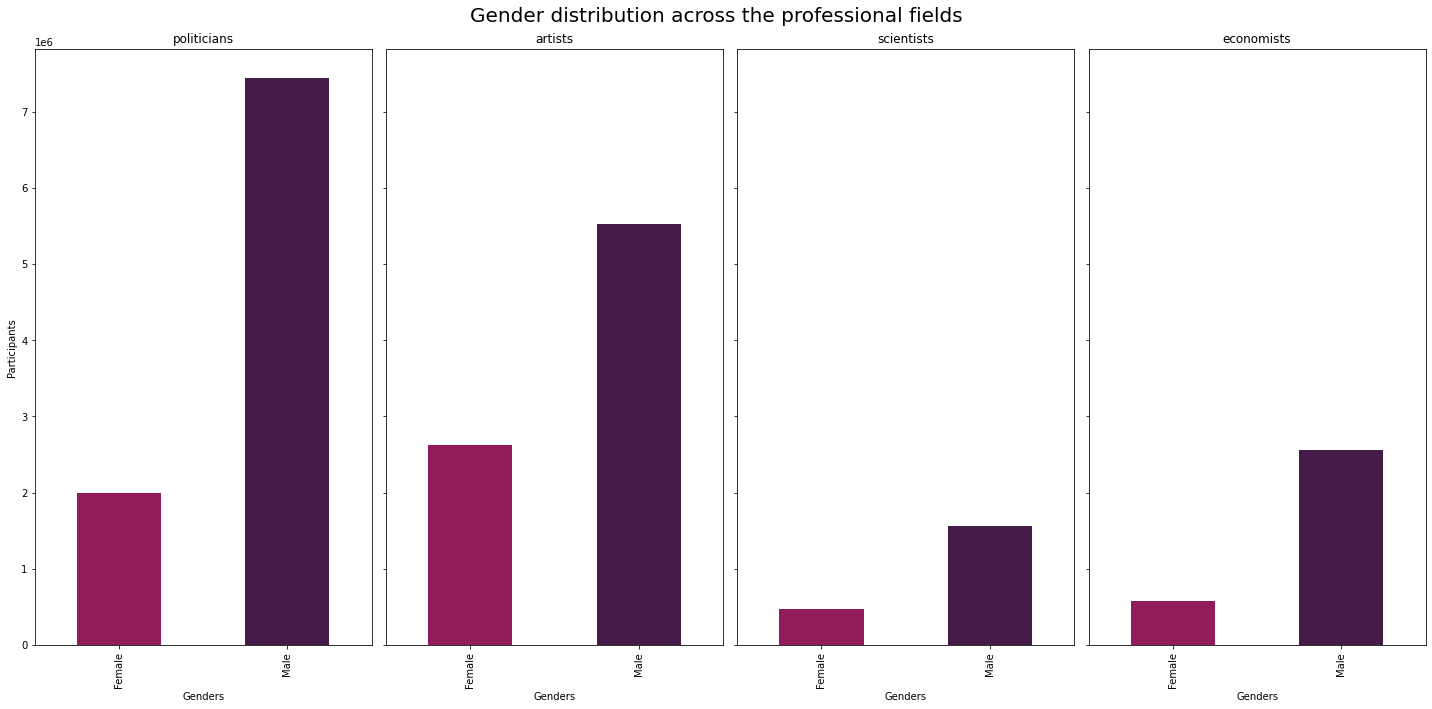

In [13]:
# To have a more readable x legend on the plot
gender_dist['politicians'].index = ['Female', 'Male']
gender_dist['artists'].index = ['Female', 'Male']
gender_dist['scientists'].index = ['Female', 'Male'] 
gender_dist['economists'].index = ['Female', 'Male']

fig, axs = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (20,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

for idx, profession in enumerate(gender_dist.keys()):
    gender_dist[profession].plot(kind = 'bar', color = [color_palette[3],color_palette[1]], ax = axs[idx])
    axs[idx].set_title(profession)
    axs[idx].set_xlabel('Genders')
    axs[idx].set_ylabel('Participants')

fig.suptitle('Gender distribution across the professional fields', fontsize = 20)
fig.tight_layout()
plt.show()

In [14]:
html_str = mpld3.fig_to_html(fig)
Html_file= open("Images/gender_dist_plot_across_prof.html","w")
Html_file.write(html_str)
Html_file.close()

In [ ]:
'''fig.write_html("Images/gender_dist_plot_across_prof.html")''';

#### Accross the general dataframe (containing background information)

In [10]:
# CHANGER 2020 EN 2015
gender_dist_background = df_no_conditions_per_year['2015'].groupby('gender').size()

for i in range(16,21): # A CHANGER EN (16, 21)
    gender_dist_background += df_no_conditions_per_year['20' + str(i)].groupby('gender').size()

Now we plot the distributions for the background dataframe.

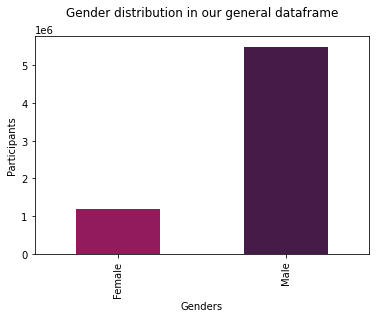

In [11]:
# To have a "more readable" x legend on the plot
gender_dist_background.index = ['Female', 'Male']

#fig = go.Figure()
fig = plt.figure()
ax = gender_dist_background.plot(kind = 'bar', color = [color_palette[3], color_palette[1]])
ax.set_title('Gender distribution in our general dataframe', pad = 20)
ax.set_ylabel('Participants')
ax.set_xlabel('Genders')
plt.show()

In [12]:
html_str = mpld3.fig_to_html(fig)
Html_file= open("Images/gender_dist_plot_across_background.html","w")
Html_file.write(html_str)
Html_file.close()

We save the plot.

In [ ]:
'''fig.write_html("Images/gender_dist_plot_across_background.html")'''

We can observe a majority of males in every occupation category, as well as in the general (background) dataframe.

#### Summary : computation of the ratios

In [15]:
# Put back "less readable" indices
gender_dist['politicians'].index = ['Q6581072', 'Q6581097']
gender_dist['artists'].index = ['Q6581072', 'Q6581097']
gender_dist['scientists'].index = ['Q6581072', 'Q6581097']
gender_dist['economists'].index = ['Q6581072', 'Q6581097']
#gender_dist_background.index = ['Q6581072', 'Q6581097']

politicians_female_ratio = gender_dist['politicians'][female_label]/gender_dist['politicians'].sum()
artist_female_ratio = gender_dist['artists'][female_label]/gender_dist['artists'].sum()
scientists_female_ratio = gender_dist['scientists'][female_label]/gender_dist['scientists'].sum()
economists_female_ratio = gender_dist['economists'][female_label]/gender_dist['economists'].sum()
#background_female_ratio = gender_dist_background[female_label]/gender_dist_background.sum()

print("The female ratio for the different occupation groups are:", "\n", 
      "{:.2f} in politicians,".format(politicians_female_ratio),
      "\n",  "{:.2f} in artist,".format(artist_female_ratio), "\n", 
      "{:.2f} in scientists,".format(scientists_female_ratio),
      "\n", "{:.2f} in economists,".format(economists_female_ratio), "\n")#,
      #"and {:.2f} accross all different occupations.".format(background_female_ratio))

The female ratio for the different occupation groups are: 
 0.21 in politicians, 
 0.32 in artist, 
 0.23 in scientists, 
 0.18 in economists, 



In [13]:
gender_dist_background.index = ['Q6581072', 'Q6581097']
background_female_ratio = gender_dist_background[female_label]/gender_dist_background.sum()
print("The female ratio for the different occupation groups are:", "\n",
"and {:.2f} accross all different occupations.".format(background_female_ratio))

The female ratio for the different occupation groups are: 
 and 0.18 accross all different occupations.


This represents an important imbalance in the dataset that we will take into account during our study and futur analysis. One could note that the highest imbalance (18% of women) is in the economist professions.

In [18]:
#del gender_dist['politicians']
#del gender_dist['artists']
#del gender_dist['scientists']
#del gender_dist['economists']

### 4.2 Analysis of the genders distribution per professions <a class = anchor id="4.2"></a>

Let's compute the uncertainty genders' distributions per professions (e.g., how many uncertain artists women are there compared to the total number of artists women).

In [20]:
df_professions_all_years = {} #Changer 2020 en 2015
df_professions_all_years['politicians'] = df_per_year['df_politicians_2015']
df_professions_all_years['artists'] = df_per_year['df_artists_2015']
df_professions_all_years['scientists'] = df_per_year['df_scientists_2015']
df_professions_all_years['economists'] = df_per_year['df_economists_2015']

for i in range(16,21): #changer en 16 21
    print(i)
    df_professions_all_years['politicians'] = pd.concat([df_professions_all_years['politicians'], 
                                                              df_per_year['df_politicians_20' + str(i)]])
    
    df_professions_all_years['artists'] = pd.concat([df_professions_all_years['artists'], 
                                                              df_per_year['df_artists_20' + str(i)]])
    
    df_professions_all_years['scientists'] = pd.concat([df_professions_all_years['scientists'], 
                                                              df_per_year['df_scientists_20' + str(i)]])
    
    df_professions_all_years['economists'] = pd.concat([df_professions_all_years['economists'], 
                                                              df_per_year['df_economists_20' + str(i)]])

16


We start by creating our dictionnary (`df_uncertain_professions_per_year`) containing our uncertain quotes per profession per year. This will also later be used in part [4.4 Possible variation from 2015 to 2020](#4.4).

In [ ]:
df_uncertain_professions_per_year = {}
for i in range(15,21): # A CHANGER EN (15, 21)
    df_uncertain_professions_per_year['df_uncertain_politicians_20' + str(i)] = create_df_from_txt(PATH_TXT + \
                            "uncertainty_politicians_20" + str(i) + ".txt", df_per_year['df_politicians_20' + str(i)])
    
    df_uncertain_professions_per_year['df_uncertain_artists_20' + str(i)] = create_df_from_txt(PATH_TXT + \
                            "uncertainty_artists_20" + str(i) + ".txt", df_per_year['df_artists_20' + str(i)])
    
    df_uncertain_professions_per_year['df_uncertain_scientists_20' + str(i)] = create_df_from_txt(PATH_TXT + \
                            "uncertainty_scientists_20" + str(i) + ".txt", df_per_year['df_scientists_20' + str(i)])
    
    df_uncertain_professions_per_year['df_uncertain_economists_20' + str(i)] = create_df_from_txt(PATH_TXT + \
                            "uncertainty_economists_20" + str(i) + ".txt", df_per_year['df_economists_20' + str(i)])

We now create a dictionnary containing all uncertain quotes per profession (regrouping all years).

In [ ]:
df_uncertain_professions_all_years = {} # CHANGER 2020 EN 2015

df_uncertain_professions_all_years['politicians'] = df_uncertain_professions_per_year['df_uncertain_politicians_2015']

df_uncertain_professions_all_years['artists'] = df_uncertain_professions_per_year['df_uncertain_artists_2015']

df_uncertain_professions_all_years['scientists'] = df_uncertain_professions_per_year['df_uncertain_scientists_2015']

df_uncertain_professions_all_years['economists'] = df_uncertain_professions_per_year['df_uncertain_economists_2015']

for i in range(16,21): # A CHANGER EN (16, 21)
    df_uncertain_professions_all_years['politicians'] = pd.concat([df_uncertain_professions_all_years['politicians'],
                                        df_uncertain_professions_per_year['df_uncertain_politicians_20' + str(i)]])
    
    df_uncertain_professions_all_years['artists'] = pd.concat([df_uncertain_professions_all_years['artists'],
                                        df_uncertain_professions_per_year['df_uncertain_artists_20' + str(i)]])
    
    df_uncertain_professions_all_years['scientists'] = pd.concat([df_uncertain_professions_all_years['scientists'],
                                        df_uncertain_professions_per_year['df_uncertain_scientists_20' + str(i)]])
    
    df_uncertain_professions_all_years['economists'] = pd.concat([df_uncertain_professions_all_years['economists'],
                                        df_uncertain_professions_per_year['df_uncertain_economists_20' + str(i)]])

We now compute the gender ratios (in %) of each profession.

In [ ]:
gender_dist_ratio= {}
gender_dist_ratio['politicians'] = create_gender_dist(df_professions_all_years['politicians'], 
                                                               df_uncertain_professions_all_years['politicians'])

gender_dist_ratio['artists'] = create_gender_dist(df_professions_all_years['artists'], 
                                                               df_uncertain_professions_all_years['artists'])

gender_dist_ratio['scientists'] = create_gender_dist(df_professions_all_years['scientists'], 
                                                              df_uncertain_professions_all_years['scientists'])

gender_dist_ratio['economists'] = create_gender_dist(df_professions_all_years['economists'], 
                                                              df_uncertain_professions_all_years['economists'])

Lastly, we plot those genders' distributions per occupation.

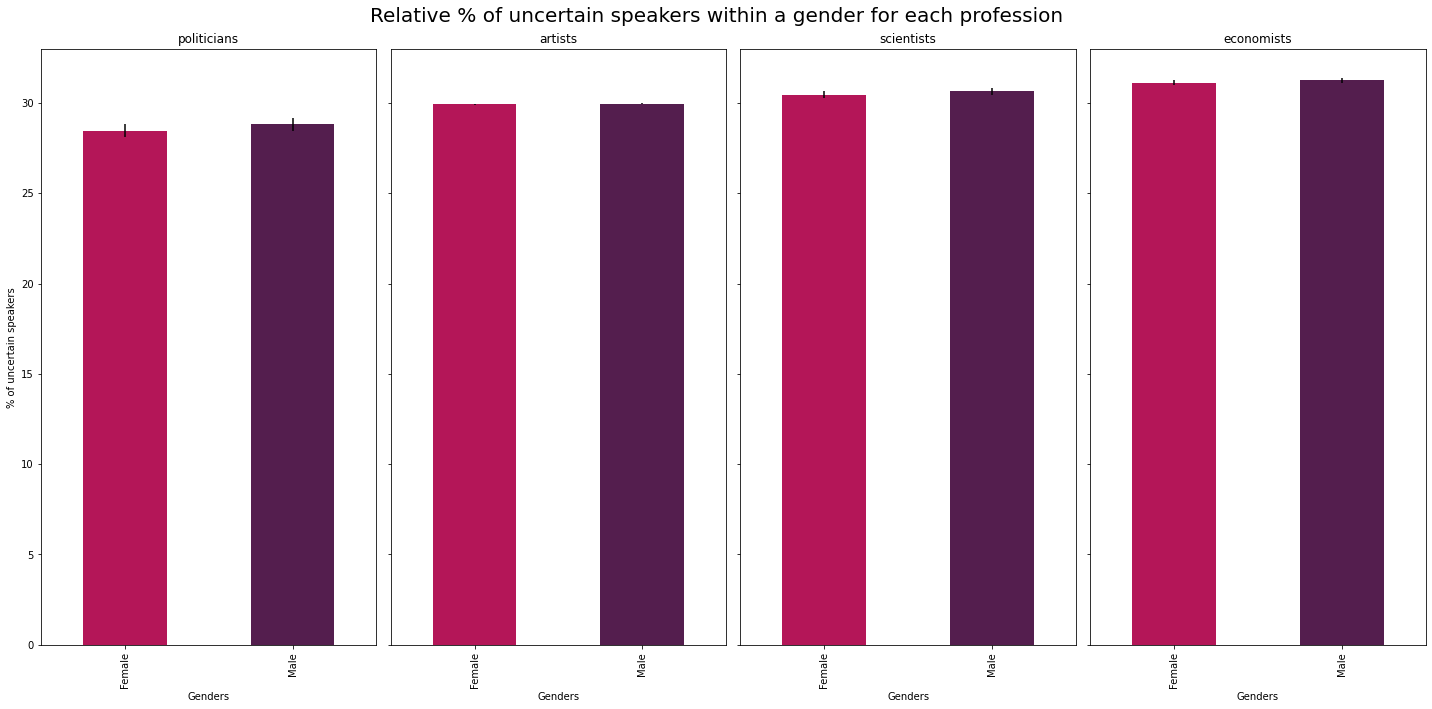

In [ ]:
# To have a more readable x legend on the plot
gender_dist_ratio['politicians'].index = ['Female', 'Male'] 
gender_dist_ratio['artists'].index = ['Female', 'Male'] 
gender_dist_ratio['scientists'].index = ['Female', 'Male'] 
gender_dist_ratio['economists'].index = ['Female', 'Male'] 

#fig = go.Figure()
fig, axs = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (20,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

for idx, profession in enumerate(gender_dist_ratio.keys()):
    double_std = np.std(gender_dist_ratio[profession]) * 2
    gender_dist_ratio[profession].plot(kind='bar', yerr = double_std, color = [color_palette[3], color_palette[1]], ax = axs[idx])
    axs[idx].set_title(profession)
    axs[idx].set_xlabel('Genders')
    axs[idx].set_ylabel('% of uncertain speakers')

fig.suptitle('Relative % of uncertain speakers within a gender for each profession', fontsize = 20)
fig.tight_layout()
plt.show()

In [ ]:
html_str = mpld3.fig_to_html(fig)
Html_file= open("Images/percentage_uncertain_plot_across_prof.html","w")
Html_file.write(html_str)
Html_file.close()

In [ ]:
'''fig.write_html("Images/percentage_uncertain_plot_across_prof.html")''';

Looking at the plots, there seems to be little differences between genders when only looking at the speakers' occupations. Analysis of significance is now performed .........

### 4.3 Background influence <a class = anchor id="4.3"></a>

Let's have a look at our second question which investigates the roles culture/traditions, education and place of living play in determining those differences in speech between men and women.

We start by creating our data frame containing our uncertain quotes.

In [14]:
# CHANGER uncertainty_df_no_conditions_2020.txt EN uncertainty_df_no_conditions_2015.txt
df_uncertain_no_conditions_all_years = create_df_from_txt(PATH_TXT + "uncertainty_df_no_conditions_2015.txt",
                                                                                df_no_conditions_per_year['2015'])

for i in range(16,21): # A CHANGER EN (16, 21)
    df_uncertain_no_conditions_new_year = create_df_from_txt(PATH_TXT + "uncertainty_df_no_conditions_20" + str(i) \
                                                                + ".txt", df_no_conditions_per_year['20' + str(i)])
    df_uncertain_no_conditions_all_years = pd.concat([df_uncertain_no_conditions_all_years,
                                                                                df_uncertain_no_conditions_new_year])

Let's first have a look at our features and which could relate to culture, education or country.

In [15]:
df_uncertain_no_conditions_all_years.columns

Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase', 'aliases', 'date_of_birth', 'nationality',
       'gender', 'lastrevid', 'ethnic_group', 'US_congress_bio_ID',
       'occupation', 'party', 'academic_degree', 'id', 'label', 'candidacy',
       'type', 'religion', 'language'],
      dtype='object')

We see that `nationality`, `ethnic_group` and `religion` could give cultural, traditional and surrounding environmental background information on the speaker, while `academic_degree` gives information on the educational aspect of the quotation's author.

In [16]:
influences = ['nationality', 'religion','ethnic_group', 'academic_degree']

Let's define the function which allows to plot the labels of each cultural and educationnal category with respect to gender.

In [17]:
def plot_influence(df, name_influence):
    df[name_influence] = qid_label.loc[df[name_influence]].Label.values
    occur = df.groupby(name_influence)[name_influence].agg('count').sort_values(ascending = False).head(20)
    df = df[df[name_influence].isin(occur.index)]
    fem = df[df['gender'] == 'Q6581072']
    mal = df[df['gender'] == 'Q6581097']
    df = pd.concat([fem[name_influence].value_counts(normalize = True), \
                    mal[name_influence].value_counts(normalize = True)], axis = 1, sort = True)
    df.columns = ["Female", "Male"]
    double_std = np.std(df) * 2
    fig = plt.figure()
    df.sort_values('Male', ascending=True).plot(kind = 'barh', xerr = double_std, figsize = (15,8), \
                                                    color = [color_palette[3],color_palette[1]])
    plt.ylabel('Normalised count')
    plt.xticks(rotation = 45, ha = "right")
    plt.title('Number of uncertain quotations in function of {} and gender'.format(name_influence))
    plt.show()

text

C:\Users\coral\anaconda3\envs\ada\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


<Figure size 432x288 with 0 Axes>

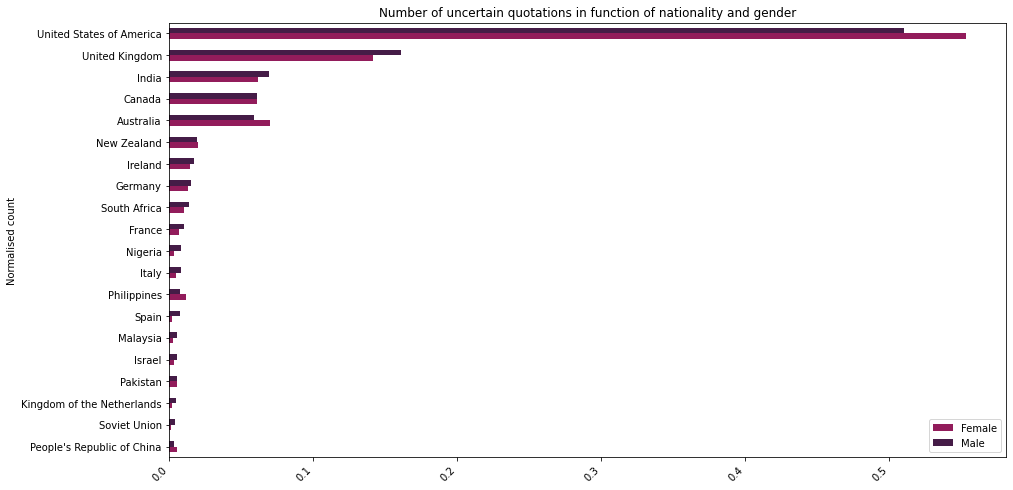

<Figure size 432x288 with 0 Axes>

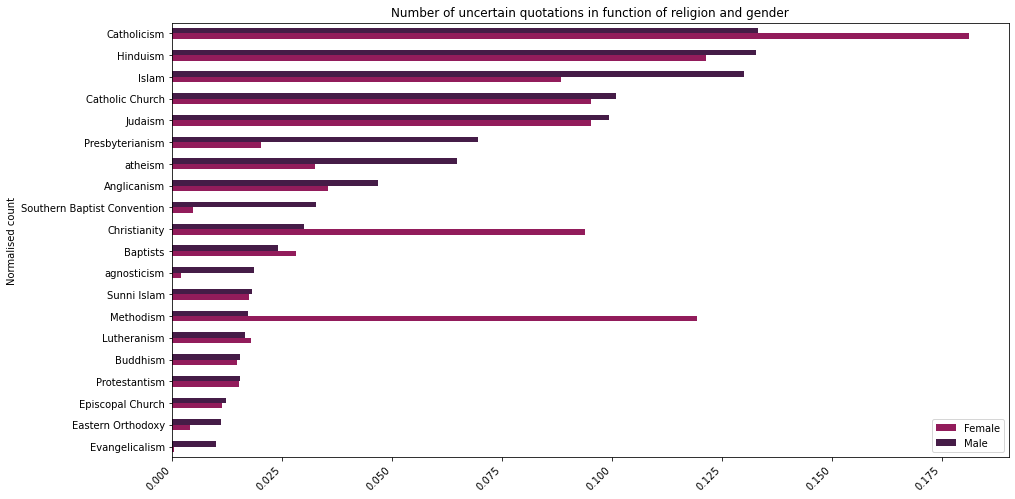

<Figure size 432x288 with 0 Axes>

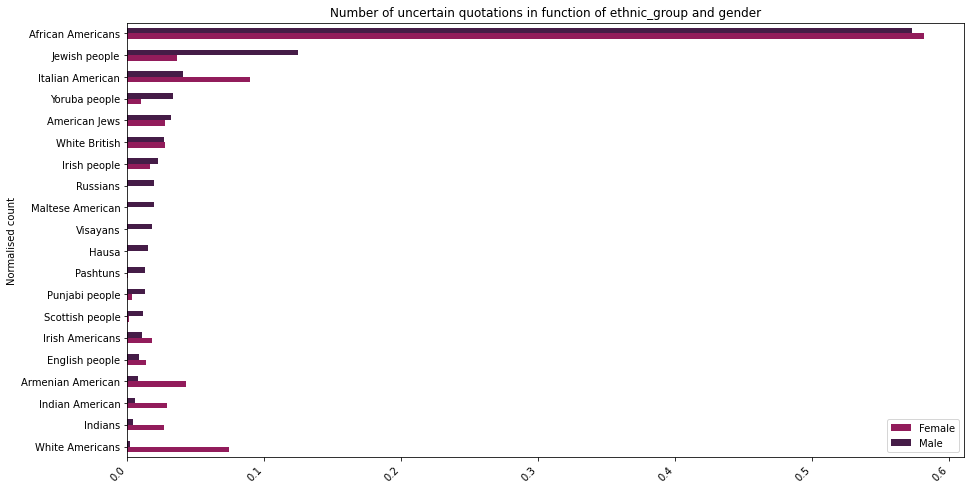

<Figure size 432x288 with 0 Axes>

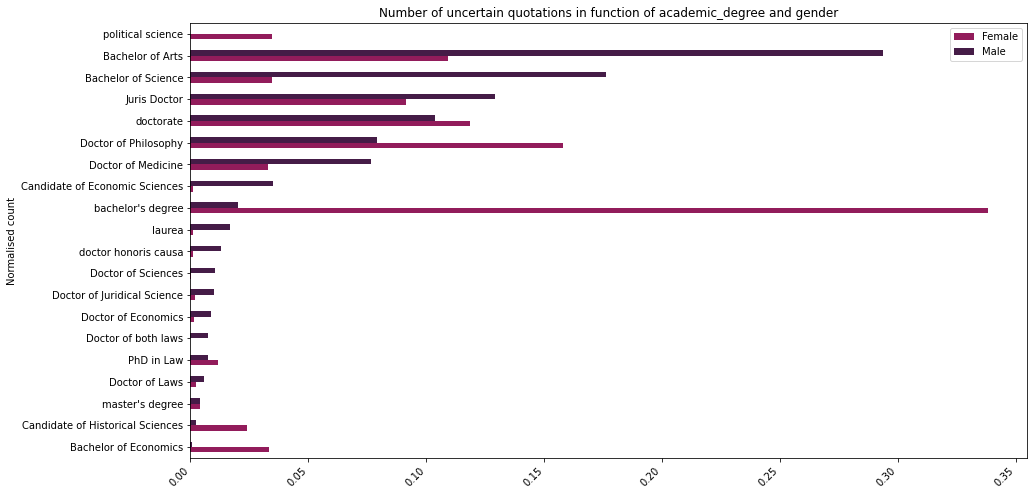

In [18]:
#fig = plt.figure()
for influence in influences:
    working_df = df_uncertain_no_conditions_all_years.copy(deep = True)
    working_df = working_df[~working_df[influence].isin([None, "None"])]
    working_df[influence] = working_df[influence].apply(lambda x: x[0])
    plot_influence(working_df, influence)

In [40]:
'''for influence in influences:
    working_df = df_uncertain_no_conditions_all_years.copy(deep = True)
    working_df = working_df[~working_df[influence].isin([None, "None"])]
    working_df[influence] = working_df[influence].apply(lambda x: x[0])
    plot_influence(working_df, influence)''';

In [19]:
html_str = mpld3.fig_to_html(fig)
Html_file= open("Images/percentage_uncertain_plot_across_background.html","w")
Html_file.write(html_str)
Html_file.close()

We see that the genders' distributions are very different depending on all conditions. Analysis of significance is now performed using hypothesis testing.

In [22]:
df_certain_no_conditions_all_years = df_no_conditions_all_years[~df_no_conditions_all_years.quoteID.isin(
                                                                df_uncertain_no_conditions_all_years.quoteID)].copy()

text

In [23]:
df_certain_no_conditions_all_years['uncertainty_label'] = 1
df_uncertain_no_conditions_all_years['uncertainty_label'] = 0

text

In [24]:
my_df = pd.concat([df_uncertain_no_conditions_all_years, df_certain_no_conditions_all_years], ignore_index = True)

text

In [27]:
res = linear_reg(data = my_df, formula = 'uncertainty_label ~ gender')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      uncertainty_label   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     16.54
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           4.76e-05
Time:                        11:11:37   Log-Likelihood:            -4.2420e+06
No. Observations:             6691519   AIC:                         8.484e+06
Df Residuals:                 6691517   BIC:                         8.484e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.7064      0

We can see that being categorised as male is correlated with a -1,66% uncertainty rate.

In [28]:
df_nat, df_rel, df_eth, df_aca = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

text

In [29]:
dict_df = {
  "nationality": df_nat,
  "religion": df_rel,
  "ethnic_group": df_eth,
  "academic_degree": df_aca
}

text

In [30]:
for influence in influences:
    print(influence)
    dict_df[influence] = my_df.copy(deep = True)
    dict_df[influence] = dict_df[influence][~dict_df[influence][influence].isin([None, "None"])]
    dict_df[influence][influence] = dict_df[influence][influence].apply(lambda x: x[0])
    dict_df[influence][influence] = qid_label.loc[dict_df[influence][influence]].Label.values
    if influence == 'nationality':
        dict_df[influence] = dict_df[influence][dict_df[influence]['nationality'].isin([
            'United States of America', 'United Kingdom', 'India', 'Canada', 'Australia'])]
        X = pd.get_dummies(dict_df[influence]['nationality'])
        dict_df[influence] = dict_df[influence].join(X)
        dict_df[influence].rename(columns = {'United States of America': 'USA', 'United Kingdom': 'UK'}, 
                                  inplace = True)
    if influence == 'religion':
        dict_df[influence] = dict_df[influence][dict_df[influence]['religion'].isin([
            'Catholicism', 'Judaism', 'Hinduism', 'Islam', 'Anglicanism'])]
        X = pd.get_dummies(dict_df[influence]['religion'])
        dict_df[influence] = dict_df[influence].join(X)
    if influence == 'academic_degree':
        dict_df[influence] = dict_df[influence][dict_df[influence]['nationality'].isin([
            'Catholicism', 'Judaism', 'Hinduism', 'Islam'])]            
    
    

    

nationality
religion
ethnic_group
academic_degree


text

In [31]:
print('United States of America: ', dict_df['nationality'][dict_df['nationality']['USA'] == 1]\
            ['uncertainty_label'].mean(), dict_df['nationality']['USA'].std(),
      '\nUnited Kingdom: ', dict_df['nationality'][dict_df['nationality']['UK'] == 1]\
            ['uncertainty_label'].mean(), dict_df['nationality']['UK'].std(),
      '\nIndia', dict_df['nationality'][dict_df['nationality']['India'] == 1]\
            ['uncertainty_label'].mean(), dict_df['nationality']['India'].std(),
      '\nCanada', dict_df['nationality'][dict_df['nationality']['Canada'] == 1]\
            ['uncertainty_label'].mean(), dict_df['nationality']['Canada'].std())

United States of America:  0.712707136676242 0.4866571075234479 
United Kingdom:  0.7069002279847135 0.38707031947458437 
India 0.6160903141767206 0.2386860366518763 
Canada 0.7036667910248894 0.2561332709851297


text

In [32]:
res_nat = linear_reg(data = dict_df['nationality'], formula = 'uncertainty_label ~ \
    USA + UK + India + Canada ')

print(res_nat.summary())

                            OLS Regression Results                            
Dep. Variable:      uncertainty_label   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3307.
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:13:39   Log-Likelihood:            -3.3649e+06
No. Observations:             5316297   AIC:                         6.730e+06
Df Residuals:                 5316292   BIC:                         6.730e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7048      0.001    947.169      0.0

text

In [33]:
encoded_df = my_df.copy()
for influence in influences:
    encoded_df = encoded_df[~encoded_df[influence].isin([None, "None"])]
    encoded_df[influence] = encoded_df[influence].apply(lambda x: x[0])
    encoded_df[influence] = qid_label.loc[encoded_df[influence]].Label.values
    if influence == 'nationality':
        encoded_df = encoded_df[encoded_df['nationality'].isin([
            'United States of America', 'United Kingdom', 'India', 'Canada', 'Australia'])]
        X = pd.get_dummies(encoded_df['nationality'])
        encoded_df = encoded_df.join(X)
        encoded_df.rename(columns = {'United States of America': 'USA', 'United Kingdom': 'UK'}, inplace = True)
        
    if influence == 'religion':
        encoded_df = encoded_df[encoded_df['religion'].isin([
            'Catholicism', 'Judaism', 'Hinduism', 'Islam'])] 
        X = pd.get_dummies(encoded_df['religion'])
        encoded_df = encoded_df.join(X)

text

### 4.4 Possible variation from 2015 to 2020 <a class = anchor id="4.4"></a>

Finally, we want to see if those distributions would vary between years. Let's compare the possible change between 2015 and 2020 concerning speech uncertainty gender difference. 

#### Accross occupations

Here, again, we still separate between the different profesionnal fields. We use the previously created dictionnary containing all uncertainty quotes from each profession per year (`df_uncertain_professions_per_year`) from part [4.2 Analysis of the genders distribution per professions](#4.2)

In [77]:
gender_dist_ratio_professions_per_year = {}
for i in range(15,21): # A CHANGER EN (15, 21)
    gender_dist_ratio_professions_per_year['politicians_20' + str(i)] = \
                                            create_gender_dist(df_per_year['df_politicians_20' + str(i)],
                                            df_uncertain_professions_per_year['df_uncertain_politicians_20' + str(i)])
    gender_dist_ratio_professions_per_year['artists_20' + str(i)] = \
                                            create_gender_dist(df_per_year['df_artists_20' + str(i)],
                                            df_uncertain_professions_per_year['df_uncertain_artists_20' + str(i)])
    gender_dist_ratio_professions_per_year['scientists_20' + str(i)] = \
                                            create_gender_dist(df_per_year['df_scientists_20' + str(i)],
                                            df_uncertain_professions_per_year['df_uncertain_scientists_20' + str(i)])
    gender_dist_ratio_professions_per_year['economists_20' + str(i)] = \
                                            create_gender_dist(df_per_year['df_economists_20' + str(i)],
                                            df_uncertain_professions_per_year['df_uncertain_economists_20' + str(i)])

We visualise our ratio in percentages in a table.

In [78]:
df = pd.DataFrame(gender_dist_ratio_professions_per_year)
df.index = ['Female', 'Male']
df

,politicians_2015,artists_2015,scientists_2015,economists_2015,politicians_2016,artists_2016,scientists_2016,economists_2016,politicians_2017,artists_2017,scientists_2017,economists_2017,politicians_2018,artists_2018,scientists_2018,economists_2018,politicians_2019,artists_2019,scientists_2019,economists_2019
Female,28.694519,29.120801,30.265207,30.810838,28.043632,29.022887,29.91702,31.030883,28.429220,29.802575,29.940541,31.347016,28.678128,30.330383,30.747642,30.988481,28.331232,30.70298,31.148003,31.421006
Male,28.712744,29.295425,30.695099,30.547771,28.543544,29.336593,30.20894,31.498905,28.680511,29.677469,30.194326,31.742690,28.986311,30.273817,30.687832,31.331042,29.054757,31.04372,31.381400,31.332961


We plot the change in distributions of uncertain speakers from 2015 to 2020 in our four professional fields.

In [39]:
"""#Faire un grand graph par profession avec courbe et points selon années
fig, axs = plt.subplots(1, 4,figsize = (15,5))

professions = ['politicians', 'artists', 'scientists', 'economists']

for idx, profession in enumerate(professions):
    df = pd.concat([professions_2015_df[idx], professions_2020_df[idx]],axis = 1)
    df.index = ['female', 'male']
    df.columns = ['2015', '2020'] 
    double_std = np.std(df) * 2
    df.plot(kind = 'bar', yerr = double_std, ax = axs[idx], color = [color_palette[4],color_palette[2]])
    axs[idx].set_ylabel('% of uncertain {}'.format(profession))
    axs[idx].set_title('Relative % of uncertain \n {a}s from 2015 to 2020'.format(a = profession), pad = 20)

plt.show()    

df.index = ['Female', 'Male']
df.plot(kind = 'bar', color = [color_palette[4], color_palette[3], color_palette[2],color_palette[1],color_palette[0]])
plt.xlabel('Gender')
plt.ylabel('% of uncertain speakers')
plt.title('Relative % of uncertain speakers from 2015 to 2020 in our general dataframe', pad = 20)
plt.show()""";

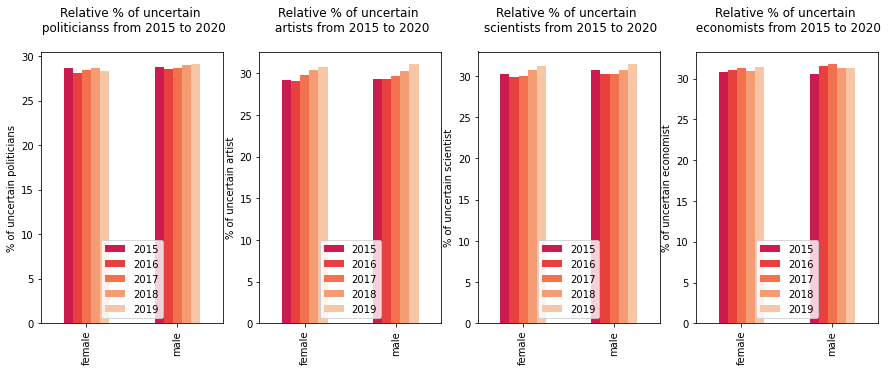

In [86]:
# PLOT A MODIFIER
fig, axs = plt.subplots(1, 4,figsize = (15,5))

professions = ['politicians', 'artist', 'scientist', 'economist']
test = {}
for i in range(15,21):
    test['20' + str(i)] = [gender_dist_ratio_professions_per_year['politicians_20' + str(i)], gender_dist_ratio_professions_per_year['artists_20' + str(i)],
                            gender_dist_ratio_professions_per_year['scientists_20' + str(i)], gender_dist_ratio_professions_per_year['economists_20' + str(i)]]
#professions_2020_df = [gender_dist_ratio_politicians, gender_dist_ratio_artists, gender_dist_ratio_scientists, \
#                       gender_dist_ratio_economists]
#professions_2015_df = [politicians_gender_dist_2015, artists_gender_dist_2015, scientists_gender_dist_2015, \
#                       economists_gender_dist_2015]

for idx, profession in enumerate(professions):
    df = pd.concat([test['2015'][idx], test['2016'][idx],test['2017'][idx],test['2018'][idx], test['2019'][idx], test['2020'][idx]],axis = 1) #
    df.index = ['female', 'male']
    df.columns = ['2015','2016', '2017', '2018', '2019', '2020']
    double_std = np.std(df) * 2
    df.plot(kind = 'bar', yerr = double_std, ax = axs[idx], color = [color_palette[4],color_palette[5],color_palette[6],color_palette[7],color_palette[8]])
    axs[idx].set_ylabel('% of uncertain {}'.format(profession))
    axs[idx].set_title('Relative % of uncertain \n {a}s from 2015 to 2020'.format(a = profession), pad = 20)

plt.show()

Again, we see that that the genders' distributions are slightly different depending on the profession. Statistical analysis...

#### Accross the general dataframe (containing background information)

We start by creating our data frames containing our uncertain quotes in the general dataframe per year.

In [34]:
df_uncertain_no_conditions_per_year = {}
for i in range(15,21): # A CHANGER EN (15, 21)
    df_uncertain_no_conditions_per_year['20' + str(i)] = create_df_from_txt(PATH_TXT + \
                                                                "uncertainty_df_no_conditions_20" + str(i) + ".txt",
                                                                df_no_conditions_per_year['20' + str(i)])

We compute our Female/Male ratios.

In [35]:
gender_dist_ratio_no_conditions_per_year = {}
for i in range(15,21): # A CHANGER EN (15, 21)
    gender_dist_ratio_no_conditions_per_year['20' + str(i)] = create_gender_dist(df_no_conditions_per_year['20' +
                                                          str(i)], df_uncertain_no_conditions_per_year['20' + str(i)])

The uncertainty percentages per gender per year are displayed in the following table.

In [36]:
df2 = pd.DataFrame(gender_dist_ratio_no_conditions_per_year)
df2.index = ['Female', 'Male']
df2

,2015,2016,2017,2018,2019,2020
Female,28.867058,28.257993,28.959768,29.48953,29.644525,29.775839
Male,28.766738,28.675188,29.064144,29.39132,29.939631,30.305889


Finally, we visualise our distributions from 2015 to 2020.

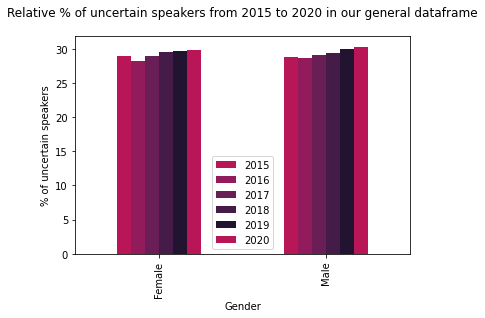

In [37]:
df2.index = ['Female', 'Male']
df2.plot(kind = 'bar', color = [color_palette[4], color_palette[3], color_palette[2], color_palette[1], 
                                color_palette[0]])
plt.xlabel('Gender')
plt.ylabel('% of uncertain speakers')
plt.title('Relative % of uncertain speakers from 2015 to 2020 in our general dataframe', pad = 20)
plt.show()

In [38]:
html_str = mpld3.fig_to_html(fig)
Html_file= open("Images/gender_dist_plot_uncertain_across_time_across_background.html","w")
Html_file.write(html_str)
Html_file.close()

Statistical analysis...

## 5. Interpretation of results <a class = anchor id="interpretation"></a>

(OLD TEXT)

Through this notebook, we aimed to analyse the speech difference between women and men using the Quotebank dataset. We started from the hypothesis that women speak less confidently than men and in a more uncertain way. To verify this claim, we conducted an analysis with the help of a classifier which distinguishes uncertain quotations from certain quotation. We also used Wikidata as a supplement input data to study more closely the quotation speakers.   
We performed various data frame separation with respect to the `occupation`, `religion`, `nationality` and `education`, to be able to measure the impact of each influence and to remove out the bias. For our initial question, it seems that there is no significant difference between men and women when compared in the same field of work. However, there seems that women in some culture or education level do show speech uncertainty more than men. However, it is important to follow these intial suggestions by a robust data statistical analysis with hypothesis testing.   
As a continuation of our milestone 2, it would be interesting to dive deeper on the statistical analysis of our findings as well as generalize to all of our quotebank dataset from 2015 up to 2020.